# Week 2: Diving deeper into the BBC News archive

Welcome! In this assignment you will be revisiting the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective labels. 

This time you will not only work with the tokenization process but you will also create a classifier using specialized layers for text data such as Embedding and GlobalAveragePooling1D.

Let's get started!

In [10]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

You probably remember structure of the csv that contains the data from last week, but in case you need a reminder run the next cell:

In [11]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

As you can see, each data point is composed of the category of the news article followed by a comma and then the actual text of the article.

## Defining useful global variables

Next you will define some global variables that will be used throughout the assignment. 

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

**For now leave them unchanged but after submitting your assignment for grading you are encouraged to come back here and play with these parameters to see the impact they have in the classification process**

In [12]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Loading and pre-processing the data

Now you should code the functions to remove stopwords from text and to load the data from a csv file.

Since you already coded these functions for the previous week, these are provided for you.

In [13]:
def remove_stopwords(sentence):
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    
    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


def parse_data_from_file(filename):
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = row[1]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

    return sentences, labels

In [14]:
# Test the functions
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


***Expected Output:***

```
There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']
```

## Training - Validation Split

Now you will code the `train_val_split`, which given the list of sentences, the list of labels and the proportion of data for the training set, should return the training and validation sentences and labels:

In [35]:
# GRADED FUNCTIONS: train_val_split
def train_val_split(sentences, labels, training_split):
    
    import numpy as np
    import random

    ### START CODE HERE
    
    # training_split = fraction of data destined to training. Example:
    # training_split = 0.8 uses 0.8 = 80% of data for training; and 0.2 = 20%
    # for testing the model

    # sentences = list of sentences that will be analyzed
    total_of_sentences = len(sentences)

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(np.rint(training_split * total_of_sentences))
    
    # We must use the int function to guarantee that the train_size will store an
    # integer number of sentences (we cannot have a fraction of a sentence).
    # The int function guarantees that the variable will be stored as an integer.
    # The numpy.rint(a) function rounds elements of the array to the nearest integer.
    # https://numpy.org/doc/stable/reference/generated/numpy.rint.html
    # For values exactly halfway between rounded decimal values, 
    # NumPy rounds to the nearest even value. 
    # Thus 1.5 and 2.5 round to 2.0; -0.5 and 0.5 round to 0.0; etc.

    #Get total of sentences used for testing:
    test_size = total_of_sentences - train_size

    # Let's create a list of indices, which goes from zero to the index of the
    # last sentence, total_of_sentences - 1:
    list_of_indices = []
    for i in range(total_of_sentences):
      # Loops from i = 0 to i = total_of_sentences - 1
      # append i to the list:
      list_of_indices.append(i)

    # Function random.sample(input_list, number_of_samples): this function creates a list containing
    # a total of elements equals to the parameter "number_of_samples", which must be an integer.
    # This list is obtained by ramdomly selecting a total of "number_of_samples" elements from the
    # list "input_list" passed as parameter.

    # Now we can create a list of random indices correspondent to the sentences (and their labels)
    # selected for training.
    # For that, random sample a total of 'train_size' elements from list_of_indices
    training_indices = random.sample(list_of_indices, train_size)

    # Split the sentences and labels into train/validation splits.
    # Firstly, start the new lists for training and validation:
    train_sentences = []
    train_labels = []

    validation_sentences = []
    validation_labels = []

    # Loop through list_of_indices.
    # If the index is in the list training_indices of the indexes selected for
    # training, append the sentence to train_sentences; and the correspondent
    # label to train_labels. If not, append them to validation_sentences and
    # validation_labels.
    # Notice that we created the indices as unique integers starting from zero,
    # so there is no equal index.

    for i in list_of_indices:
      # Loops through each element i in the list of indices.

      # Check if i is in the list training_indices
      if (i in training_indices):
        # append the sentence and its label to the training list:
        train_sentences.append(sentences[i])
        train_labels.append(labels[i])
      
      else:
        # i is not an index selected for training.
        # append the elements to the validation lists:
        validation_sentences.append(sentences[i])
        validation_labels.append(labels[i])

    ### END CODE HERE
    
    return train_sentences, validation_sentences, train_labels, validation_labels

In [43]:
# Test your function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


***Expected Output:***

```
There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.
```

## Tokenization - Sequences and padding

Now that you have sets for training and validation it is time for you to begin the tokenization process.

Begin by completing the `fit_tokenizer` function below. This function should return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to the training sentences.

In [37]:
# GRADED FUNCTION: fit_tokenizer
def fit_tokenizer(train_sentences, num_words, oov_token):
    
    from tensorflow.keras.preprocessing.text import Tokenizer
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    # oov: out of vocabulary - it should be a special token different from any possible word
    # to differentiate the words that are present, but were not seem when creating the word index.
    # If there is no token for words out of the vocabulary, the words would be simply removed when
    # encoding the sequence. Now, instead of removing those words, we encode them as the special
    # token oov_token, such as '<OOV>'.
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [44]:
# Test your function
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27234 words

<OOV> token included in vocabulary


***Expected Output:***

```
Vocabulary contains 27285 words

<OOV> token included in vocabulary
```

Now that the tokenizer has been fitted to the training data, you need a function that will convert each text data point into its padded sequence representation, for this complete the `seq_and_pad` function below:

In [45]:
# GRADED FUNCTION: seq_and_pad
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, padding = padding, truncating = padding, maxlen = maxlen)
    # Keras requires sequences of the same lenght: same number of variables (columns); images of
    # constant dimensions; or text sequences with same length
    # maxlen: set the maximum length allowed for the sequences. Longer sequences will be truncated
    # after reaching the number of tokens specified as maxlen. If maxlen = 5, the sequences are
    # allowed to have only 5 tokens (5 words, basically).

    # The default for padding and truncating is in the beginning of the sentence: then, zeros are added to
    # the beginning of the smaller sequences (their left, before the first words). The number of added zeros
    # is the amount required for them to reach the maximum possible length. In turns, sequences longer than
    # the maximum possible length are cropped (truncated) in their left, i.e., their first words are removed
    # for them to reach the maximum allowed length.
    # By specifying padding = 'post', we tell keras that the zeros should be added at the end (far-right) 
    # of the sequences, so only what comes after the sentence is 'modified' 
    # (filled with zeros to reach the maximum length).

    # In its turn, when specifying truncating = 'post', we tell Keras to remove only the last (far-
    # right) words, so the beginning of the sentences longer than max length are not removed (we lost
    # the final part of the text, instead of losing its beginning).
    
    ### END CODE HERE
    
    return padded_sequences

In [46]:
# Test your function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


***Expected Output:***

```
Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)
```

Finally you need to tokenize the labels. For this complete the `tokenize_labels` function below.

A couple of things to note:
- You should fit the tokenizer to all the labels to avoid the case of a particular label not being present in the validation set. Since you are dealing with labels there should never be an OOV label.


- In the previous function you used the `pad_sequences` function which returns numpy arrays. Here you will not be using it since you don't need to pad the labels so you need to make the conversion to numpy arrays yourself.


- The argument `split_labels` refers to the labels of a particular split (train or validation). This is because the function should work independently of the split being used.


- Using Keras' Tokenizer yields values that start at 1 rather than at 0. This will present a problem when training since Keras usually expects the labels to start at 0. To work around this issue you could use an extra neuron in the last layer of your model. However this approach is rather hacky and not very clear. Instead you will substract 1 from every value of the labels that the function returns. Remember that when using numpy arrays you can simply do something like `np.array - 1` to accomplish this since numpy allows for vectorized operations.

In [47]:
# GRADED FUNCTION: tokenize_labels
def tokenize_labels(all_labels, split_labels):
    
    import numpy as np
    from tensorflow.keras.preprocessing.text import Tokenizer
    ### START CODE HERE
    
    # Instantiate the Tokenizer (no additional arguments needed)
    # So, do not pass the oov token.
    label_tokenizer = Tokenizer()
    
    # Fit the tokenizer on all the labels
    # This will avoid having the OOV token when analyzing a validation sentence.
    # The OOV token would be present if we fitted the tokenizer to only the 
    # training labels and the validation labels contain vocabulary that were not
    # used for fitting, i.e., words that are not in the vocabulary.
    label_tokenizer.fit_on_texts(all_labels)
    
    # Convert labels to sequences
    # Convert only the labels passed as split_labels. 
    # split_labels are the train_labels, when tokenizing the training data.
    # split_labels are the validation_labels, when tokenizing the validation data.
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    
    # Convert sequences to a numpy array. Don't forget to substact 1 from every entry in the array!
    label_seq_np = np.array(label_seq)
    # subtract 1: Using Keras' Tokenizer yields values that start at 1 rather than at 0. 
    # This will present a problem when training since Keras usually expects the labels to start at 0. 
    # So, we substract 1 from every value of the labels that the function returns. 
    # When using numpy arrays you can simply do something like np.array - 1 to accomplish this,
    # since numpy allows for vectorized operations.
    label_seq_np = label_seq_np - 1
    
    ### END CODE HERE
    
    return label_seq_np

In [48]:
# Test your function
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [2]]

First 5 labels of the validation set should look like this:
[[4]
 [4]
 [0]
 [0]
 [2]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



***Expected Output:***

```
First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)
```

## Selecting the model for text classification

Now that the data is ready to be fed a Neural Network it is time for you to define the model that will classify each text as being part of a certain category. 

For this complete the `create_model` below. 

A couple of things to keep in mind:

- Notice that this function has three parameters, all of which are meant to be passed to an [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer, which is what you will probably use as a first layer for your model.


- The last layer should be a Dense layer with 5 units (since there are 5 categories) with a softmax activation.


- You should also compile your model using an appropiate loss function and optimizer.


- You can use any architecture you want but keep in mind that this problem doesn't need many layers to be solved successfully. You don't need any layers beside Embedding, [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) and Dense layers but feel free to try out different architectures.


- **To pass this graded function your model should reach at least a 95% training accuracy and a 90% validation accuracy in under 30 epochs.**

In [59]:
# GRADED FUNCTION: create_model
def create_model(num_words, embedding_dim, maxlen):
    
    import tensorflow as tf

    tf.random.set_seed(123)
    
    ### START CODE HERE
    
    # embedding_dim: Define dimensionality of the embedding
    # It is the number of dimensions of the embedding vectors - 
    # conversion of words into vectors in an N-dimensional space that minimizes 
    # the distance between vectors correspondent to words from the same semantical field 
    # (i.e., similar meaning or feeling). Each vector has embedding_dim dimensions,
    # where each dimension of the vector is occupied by a float value.

    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length = maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
        # There are 5 neurons (units) activated through 'softmax', since there
        # are 5 possible categories.
    ])
    
    model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy']) 
    # we use 'sparse_categorical_crossentropy' because there are multiple categories.
    # If fewer categories were present, we could use 'sparse_categorical_crossentropy'
    # instead.

    ### END CODE HERE

    return model


In [60]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 7ms/step - loss: 1.5977 - accuracy: 0.3449 - val_loss: 1.5761 - val_accuracy: 0.4360
Epoch 2/30
56/56 [==============================] - 0s 4ms/step - loss: 1.5206 - accuracy: 0.4764 - val_loss: 1.4391 - val_accuracy: 0.4787
Epoch 3/30
56/56 [==============================] - 0s 5ms/step - loss: 1.2904 - accuracy: 0.5876 - val_loss: 1.1310 - val_accuracy: 0.7281
Epoch 4/30
56/56 [==============================] - 0s 3ms/step - loss: 0.9454 - accuracy: 0.8034 - val_loss: 0.8047 - val_accuracy: 0.8831
Epoch 5/30
56/56 [==============================] - 0s 5ms/step - loss: 0.6385 - accuracy: 0.9028 - val_loss: 0.5523 - val_accuracy: 0.9258
Epoch 6/30
56/56 [==============================] - 0s 3ms/step - loss: 0.4252 - accuracy: 0.9354 - val_loss: 0.4014 - val_accuracy: 0.9258
Epoch 7/30
56/56 [==============================] - 0s 4ms/step - loss: 0.3012 - accuracy: 0.9483 - val_loss: 0.3175 - val_accuracy: 0.9348
Epoch 8/30
56/56 [==

Once training has finished you can run the following cell to check the training and validation accuracy achieved at the end of each epoch.

**Remember that to pass this assignment your model should achieve a training accuracy of at least 95% and a validation accuracy of at least 90%. If your model didn't achieve these thresholds, try training again with a different model architecture.**

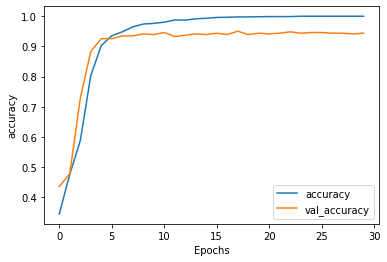

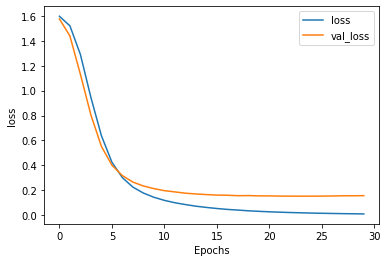

In [61]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**If your model passes the previously mentioned thresholds be sure to save your notebook and submit for grading before jumping onto the next section.**

## Optional Exercise - Visualizing 3D Vectors

As you saw on the lecture you can visualize the vectors associated with each word in the training set in a 3D space.

For this run the following cells and visit [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [62]:
# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


***Expected Output:***

```
Weights of embedding layer have shape: (1000, 16) 

The above is true if global variables are not modified. 
Notice that this shape will always be (NUM_WORDS, EMBEDDING_DIM).

```

Now run the following cell to generate the `vecs.tsv` and `meta.tsv` files that you will upload to the embedding projector.

In [63]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

Before downloading these files be sure to having already submitted your assignment.


By running the previous cell, these files are placed within your filesystem. To download them, click on the `Jupyter` logo on the upper-left side of the screen. This will take you to the Jupyter filesystem and there you can download the files by selecting them and clicking on the `Download` button.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of classifying text and also learned about embeddings and tokenization along the way!

**Keep it up!**